In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import pathlib
from pathlib import Path
import xml.etree.ElementTree as ET
from glob import glob
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
IMAGES_ROOT = Path("Images")
XML_ROOT = Path("annotations") / "Annotation"

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16            # recommended for 6GB; set 8 if still OOM
VALIDATION_SPLIT = 0.2
SEED = 123
EPOCHS_FROZEN = 6
EPOCHS_FINE_TUNE = 15
UNFREEZE_TOP_LAYERS = 8
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
CHECKPOINT = "best_convnext_conv_crop.keras"
OUTPUT_MODEL = "convnext_conv_crop_finetuned.keras"

In [5]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy:", mixed_precision.global_policy())

Mixed precision policy: <DTypePolicy "mixed_float16">


In [6]:
# GPU check and memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass
print("GPUs:", gpus)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
image_root = Path(IMAGES_ROOT)
xml_root = Path(XML_ROOT)

#check if paths exist
assert image_root.exists(), f"Image root path {image_root} does not exist."
assert xml_root.exists(), f"XML root path {xml_root} does not exist."

print(f"Image root path: {image_root.exists()}")
print(f"XML root path: {xml_root.exists()}")

Image root path: True
XML root path: True


In [8]:
# Get class names from subdirectory names
classes = sorted([p.name for p in image_root.iterdir() if p.is_dir()])
num_classes = len(classes)
class_to_index = {c: i for i, c in enumerate(classes)}
print(f"Found {num_classes} classes") # found 120 classes

Found 120 classes


In [9]:
image_paths = []
bboxes_norm = []
labels = []

In [10]:
def parse_xml_get_bbox(xml_path):
    # return tuple (xmin,ymin,xmax,ymax) ints or None
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        obj = root.find('object')
        if obj is None:
            return None
        bnd = obj.find('bndbox')
        xmin = int(float(bnd.find('xmin').text))
        ymin = int(float(bnd.find('ymin').text))
        xmax = int(float(bnd.find('xmax').text))
        ymax = int(float(bnd.find('ymax').text))
        return xmin, ymin, xmax, ymax
    except Exception:
        return None

In [11]:
print("Scanning images and XMLs (this may take a bit)...")
for cls in classes:
    img_dir = image_root / cls
    xml_dir = xml_root / cls
    if not img_dir.exists():
        continue
    for img_file in img_dir.iterdir():
        if img_file.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue
        stem = img_file.stem
        # try .xml then no-extension file
        xml_candidate1 = xml_dir / (stem + ".xml")
        xml_candidate2 = xml_dir / stem
        chosen_xml = None
        if xml_candidate1.exists():
            chosen_xml = xml_candidate1
        elif xml_candidate2.exists():
            chosen_xml = xml_candidate2
        else:
            # skip if no xml (optional: include full image as fallback; here we skip)
            continue

        # parse xml and create normalized bbox
        bbox = parse_xml_get_bbox(str(chosen_xml))
        if bbox is None:
            # fallback: include whole image (0,0,w,h) — we compute normalized later using image size
            # store sentinel (-1) to indicate full-image fallback
            image_paths.append(str(img_file))
            bboxes_norm.append((-1, -1, -1, -1))
            labels.append(class_to_index[cls])
            continue

        # read image size to normalize
        # we'll load dims quickly using PIL to avoid decoding each time in TF pipeline
        from PIL import Image
        with Image.open(img_file) as im:
            w, h = im.size

        xmin, ymin, xmax, ymax = bbox
        # clip
        xmin = max(0, min(xmin, w-1))
        ymin = max(0, min(ymin, h-1))
        xmax = max(xmin+1, min(xmax, w))
        ymax = max(ymin+1, min(ymax, h))
        # convert to normalized [ymin, xmin, ymax, xmax] for tf.image.crop_and_resize
        y1 = ymin / h
        x1 = xmin / w
        y2 = ymax / h
        x2 = xmax / w
        image_paths.append(str(img_file))
        bboxes_norm.append((y1, x1, y2, x2))
        labels.append(class_to_index[cls])

print("Total items:", len(image_paths))
assert len(image_paths) > 0, "No image items found!"

Scanning images and XMLs (this may take a bit)...
Total items: 20580


In [12]:
from sklearn.model_selection import train_test_split
train_img, val_img, train_boxes, val_boxes, train_lbl, val_lbl = train_test_split(
    image_paths, bboxes_norm, labels, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=labels
)
print("Train:", len(train_img), "Val:", len(val_img))

Train: 16464 Val: 4116


In [13]:
# Convert lists to numpy arrays for from_tensor_slices
train_img = np.array(train_img, dtype=np.bytes_)
val_img = np.array(val_img, dtype=np.bytes_)
train_boxes = np.array(train_boxes, dtype=np.float32)
val_boxes = np.array(val_boxes, dtype=np.float32)
train_lbl = np.array(train_lbl, dtype=np.int32)
val_lbl = np.array(val_lbl, dtype=np.int32)


In [14]:
def make_dataset(image_paths_np, boxes_np, labels_np, is_train=True):
    ds = tf.data.Dataset.from_tensor_slices((image_paths_np, boxes_np, labels_np))
    if is_train:
        ds = ds.shuffle(4096, seed=SEED)

    def _load_and_crop(path, box, label):
        # path: scalar string tensor; box: [y1,x1,y2,x2] (may be -1 sentinel)
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        img = tf.cast(img, tf.float32)  # will be in range [0,255] typically

        # if box is sentinel (-1,-1,-1,-1) -> use full image normalized box
        sentinel = tf.reduce_all(tf.equal(box, tf.constant([-1.0, -1.0, -1.0, -1.0], dtype=tf.float32)))
        def use_full():
            h = tf.cast(tf.shape(img)[0], tf.float32)
            w = tf.cast(tf.shape(img)[1], tf.float32)
            return tf.stack([0.0, 0.0, 1.0, 1.0])
        def use_bbox():
            # ensure box values are clipped 0..1
            y1 = tf.clip_by_value(box[0], 0.0, 1.0)
            x1 = tf.clip_by_value(box[1], 0.0, 1.0)
            y2 = tf.clip_by_value(box[2], 0.0, 1.0)
            x2 = tf.clip_by_value(box[3], 0.0, 1.0)
            # ensure positive
            y2 = tf.maximum(y2, y1 + 1e-4)
            x2 = tf.maximum(x2, x1 + 1e-4)
            return tf.stack([y1, x1, y2, x2])
        final_box = tf.cond(sentinel, use_full, use_bbox)
        final_box = tf.reshape(final_box, (1,4))  # shape (1,4)
        # crop_and_resize requires float32 img and boxes, box_indices list
        cropped = tf.image.crop_and_resize(tf.expand_dims(img, 0), final_box, box_indices=[0], crop_size=IMG_SIZE)
        cropped = tf.squeeze(cropped, axis=0)  # (H,W,3)
        return cropped, label

    ds = ds.map(_load_and_crop, num_parallel_calls=AUTOTUNE)
    return ds

train_ds = make_dataset(train_img, train_boxes, train_lbl, is_train=True)
val_ds = make_dataset(val_img, val_boxes, val_lbl, is_train=False)

I0000 00:00:1763274530.801217   23076 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
# Use ConvNeXt preprocess if available
try:
    from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
    print("Using ConvNeXt preprocess_input")
    preprocess_fn = convnext_preprocess
except Exception:
    from tensorflow.keras.applications.imagenet_utils import preprocess_input as generic_preprocess
    preprocess_fn = generic_preprocess
    print("ConvNeXt preprocess not found, using generic preprocess_input")

Using ConvNeXt preprocess_input


In [16]:
# Keras augmentation layers (fast, run in graph)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.06),
    keras.layers.RandomZoom(0.06, 0.06),
    keras.layers.RandomTranslation(0.02, 0.02),
    keras.layers.RandomContrast(0.06),
], name="data_augmentation")

In [17]:
def train_preprocess(image, label):
    image = data_augmentation(image)
    image = preprocess_fn(image)
    return image, label

def val_preprocess(image, label):
    image = preprocess_fn(image)
    return image, label

In [18]:
train_ds = train_ds.shuffle(4096, seed=SEED)
train_ds = train_ds.map(train_preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_ds.map(val_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [19]:
# Quick sanity: look at batch shapes
for xb, yb in train_ds.take(1):
    print("Batch x:", xb.shape, "dtype:", xb.dtype, "y:", yb.shape)
    break

Batch x: (16, 224, 224, 3) dtype: <dtype: 'float16'> y: (16,)


In [20]:
try:
    from tensorflow.keras.applications.convnext import ConvNeXtTiny
    ConvNeXtClass = ConvNeXtTiny
    print("Using ConvNeXtTiny from tf.keras.applications.convnext")
except Exception:
    ConvNeXtClass = None

if ConvNeXtClass is None:
    raise ImportError("ConvNeXtTiny not available in this TF. Upgrade TensorFlow or request a PyTorch/timm notebook.")

Using ConvNeXtTiny from tf.keras.applications.convnext


In [21]:
base_model = ConvNeXtClass( input_shape=IMG_SIZE + (3,),
                        include_top=False,
                        weights='imagenet')

In [22]:
base_model.trainable = False

In [23]:
# Build head
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)

In [24]:
# final Dense must be float32 to avoid mixed-precision numeric problems in softmax
outputs = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
model = keras.Model(inputs, outputs)

In [25]:
# Compile: optimizer will be wrapped for mixed precision automatically
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        92,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,912,408 (106.48 MB)

 Trainable params: 92,280 (360.47 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [26]:
history1 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FROZEN)

Epoch 1/6


I0000 00:00:1763274562.585075   23154 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 84s 61ms/step - accuracy: 0.8219 - loss: 0.8946 - val_accuracy: 0.9174 - val_loss: 0.2739
Epoch 2/6
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 46s 42ms/step - accuracy: 0.9073 - loss: 0.3168 - val_accuracy: 0.9162 - val_loss: 0.2733
Epoch 3/6
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.9177 - loss: 0.2673 - val_accuracy: 0.9150 - val_loss: 0.2675
Epoch 4/6
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.9241 - loss: 0.2398 - val_accuracy: 0.9210 - val_loss: 0.2692
Epoch 5/6
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 51s 47ms/step - accuracy: 0.9302 - loss: 0.2200 - val_accuracy: 0.9208 - val_loss: 0.2604
Epoch 6/6
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.9345 - loss: 0.2030 - val_accuracy: 0.9155 - val_loss: 0.2875


In [27]:
# step-1 base model trained with frozen base
print("step-1 base model trained with frozen base completed....")

step-1 base model trained with frozen base completed....


In [ ]:
#let's do few more epochs before unfreezing
# history_extra = model.fit(train_ds, validation_data=val_ds, epochs=10)

In [28]:
# history1.history['loss'].extend(history_extra.history['loss'])
# history1.history['accuracy'].extend(history_extra.history['accuracy'])
# history1.history['val_loss'].extend(history_extra.history['val_loss'])
# history1.history['val_accuracy'].extend(history_extra.history['val_accuracy'])

In [29]:
# Fine-tune: unfreeze last UNFREEZE_TOP_LAYERS layers of base_model
total_layers = len(base_model.layers)
to_unfreeze = min(UNFREEZE_TOP_LAYERS, total_layers)

In [30]:
print("Base model layers:", total_layers, "Unfreezing last:", to_unfreeze)
for layer in base_model.layers[-to_unfreeze:]:
    layer.trainable = True

Base model layers: 133 Unfreezing last: 8


In [31]:
# Recompile with very low LR for gentle fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        92,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,912,408 (106.48 MB)

 Trainable params: 4,856,952 (18.53 MB)

 Non-trainable params: 23,055,456 (87.95 MB)

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint(CHECKPOINT, monitor='val_accuracy', save_best_only=True, mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]

In [33]:
history2 = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINE_TUNE, callbacks=callbacks)

Epoch 1/15
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 91s 65ms/step - accuracy: 0.9383 - loss: 0.1833 - val_accuracy: 0.9157 - val_loss: 0.2826 - learning_rate: 1.0000e-06
Epoch 2/15
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - accuracy: 0.9411 - loss: 0.1782 - val_accuracy: 0.9169 - val_loss: 0.2786 - learning_rate: 1.0000e-06
Epoch 3/15
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 65s 60ms/step - accuracy: 0.9432 - loss: 0.1717 - val_accuracy: 0.9174 - val_loss: 0.2754 - learning_rate: 1.0000e-06
Epoch 4/15
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 61s 57ms/step - accuracy: 0.9437 - loss: 0.1725 - val_accuracy: 0.9193 - val_loss: 0.2726 - learning_rate: 1.0000e-06
Epoch 5/15
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.9448 - loss: 0.1701 - val_accuracy: 0.9198 - val_loss: 0.2706 - learning_rate: 1.0000e-06
Epoch 6/15
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 61s 56ms/step - accuracy: 0.9437 - loss: 0.1695 - val_accuracy: 0.9206 - val_loss: 0.2685 - learning_rate: 1.0000e-06
Epoch 7/15
1029/1029 ━━━━━━━━━━━━━━━━━━━

In [34]:
# step 2 fine-tuning completed
print(" step 2 fine-tuning completed...")

 step 2 fine-tuning completed...


In [35]:
#print training histories of both phases
print("history1", history1)
print("history2", history2)
print("Visualizing training history (Accuracy and Loss)...")
print("Phase 1: Frozen Base Model")
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs_range1 = range(EPOCHS_FROZEN)
print(f"Accuracy : {acc1}")
print(f"Validation Accuracy : {val_acc1}")
print(f"Loss : {loss1}")
print(f"Validation Loss : {val_loss1}")

print("Phase 2: Fine-Tuning Top Layers")
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs_range2 = range(EPOCHS_FINE_TUNE)
print(f"Accuracy : {acc2}")
print(f"Validation Accuracy : {val_acc2}")
print(f"Loss : {loss2}")
print(f"Validation Loss : {val_loss2}")

history1 <keras.src.callbacks.history.History object at 0x7faa49f290d0>
history2 <keras.src.callbacks.history.History object at 0x7faa43732ea0>
Visualizing training history (Accuracy and Loss)...
Phase 1: Frozen Base Model
Accuracy : [0.8219144940376282, 0.9072521924972534, 0.9176992177963257, 0.9240767955780029, 0.9301506280899048, 0.9345238208770752]
Validation Accuracy : [0.9173955321311951, 0.9161807298660278, 0.9149659872055054, 0.9210398197174072, 0.9207968711853027, 0.9154518842697144]
Loss : [0.8946273326873779, 0.3167587220668793, 0.2673262655735016, 0.2398102730512619, 0.2199755311012268, 0.2029716670513153]
Validation Loss : [0.27386653423309326, 0.27325618267059326, 0.26745909452438354, 0.2692185640335083, 0.26041972637176514, 0.2874637544155121]
Phase 2: Fine-Tuning Top Layers
Accuracy : [0.9382895827293396, 0.9411442875862122, 0.9432094097137451, 0.9436953067779541, 0.9448493719100952, 0.9436953067779541, 0.9453960061073303, 0.946246325969696, 0.9460641145706177, 0.949040

In [36]:
# separate plots for history1 and history2
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()

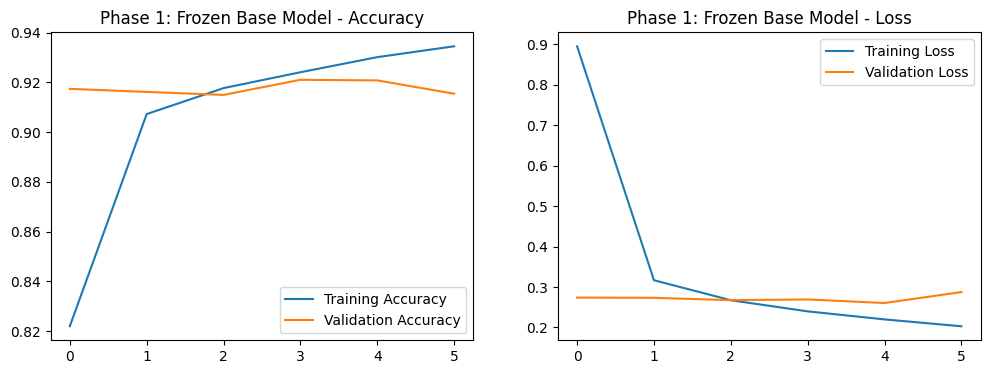

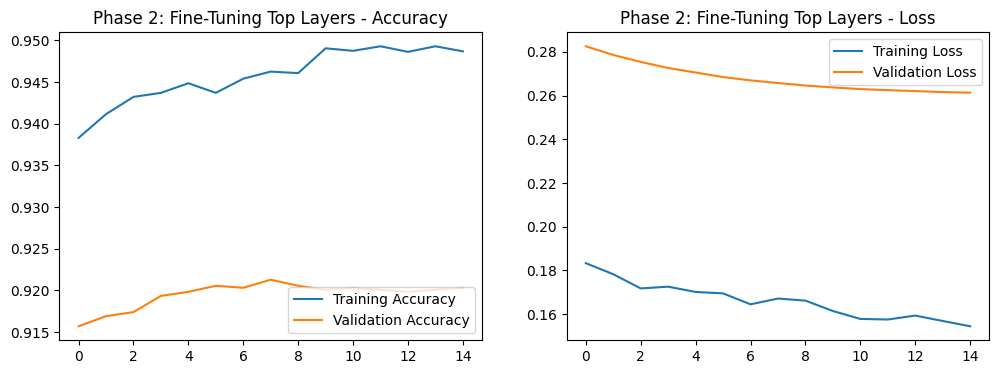

In [37]:
plot_history(history1, "Phase 1: Frozen Base Model")
plot_history(history2, "Phase 2: Fine-Tuning Top Layers")

In [38]:
# Combine histories
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs_total = range(len(acc))

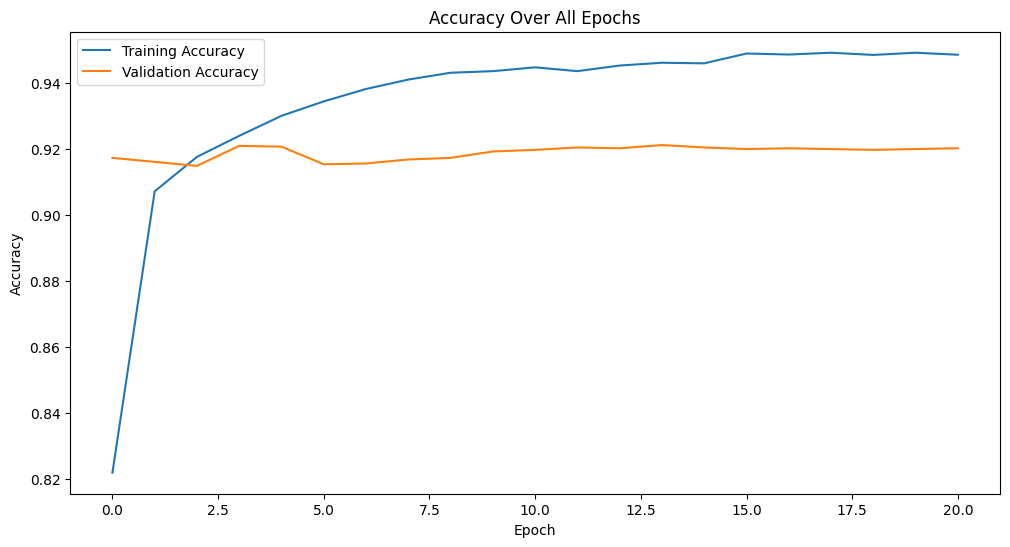

In [39]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_total, acc, label='Training Accuracy')
plt.plot(epochs_total, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over All Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


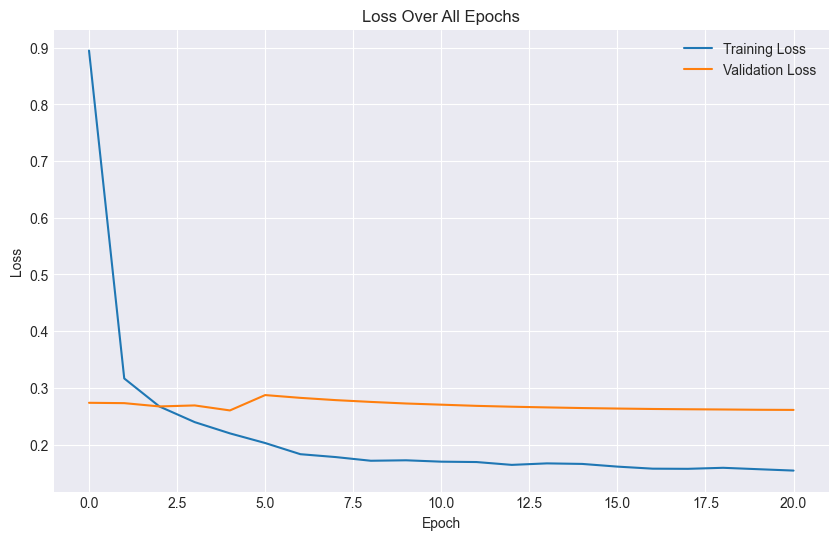

In [40]:
# Plot Loss
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(epochs_total, loss, label='Training Loss')
plt.plot(epochs_total, val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss Over All Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [41]:
# Save final model
model.save(OUTPUT_MODEL)
print("Saved model to:", OUTPUT_MODEL)

Saved model to: convnext_conv_crop_finetuned.keras


In [42]:
print("Notebook finished. Inspect logs and model file.")

Notebook finished. Inspect logs and model file.
